In [8]:
!pip install tensorflow mtcnn scikit-learn tensorflow_hub

In [9]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from mtcnn.mtcnn import MTCNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import requests
import tarfile
import random
import pickle
from google.colab import drive

In [10]:
try:
    drive.mount('/content/drive')
except:
    drive.mount('/content/drive', force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import requests
import tarfile
import os
from tqdm.notebook import tqdm

def download_and_extract_lfw(dataset_path='/content/lfw', tgz_path='/content/lfw.tgz'):
    """Downloads and extracts the LFW dataset from a stable scikit-learn source."""

    # Check if dataset already exists
    if os.path.exists(dataset_path) and os.path.isdir(dataset_path):
        print("LFW dataset already exists.")
        return dataset_path

    # This is the stable URL used by the scikit-learn library
    url = "https://ndownloader.figshare.com/files/5976018"
    print("Downloading LFW dataset from stable scikit-learn source...")

    try:
        # Download with progress bar
        response = requests.get(url, stream=True)
        response.raise_for_status()

        # Get total size from headers, default to 0 if not found
        total_size = int(response.headers.get('content-length', 0))

        with open(tgz_path, 'wb') as f, tqdm(
            desc="Downloading",
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for chunk in response.iter_content(chunk_size=8192):
                size = f.write(chunk)
                bar.update(size)

        print(f"Downloaded to {tgz_path}")

        # Extract
        print(f"Extracting to /content/...")
        # This extracts the 'lfw' folder to /content/lfw
        with tarfile.open(tgz_path, 'r:gz') as tar:
            tar.extractall(path='/content/')

        print(f"Extraction complete. Dataset is at {dataset_path}")
        os.remove(tgz_path) # Clean up the tarball
        return dataset_path

    except Exception as e:
        print(f"Error during download/extraction: {e}")
        return None

In [19]:
class FaceRecognitionSystem:
    def __init__(self):
        self.detector = MTCNN()
        # Load EfficientNet model directly using KerasLayer wrapper
        self.facenet_model_layer = hub.KerasLayer(
            'https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2',
            trainable=False
        )
        self.required_size = (160, 160) # Changed to match EfficientNet, common size
        self.embeddings = []
        self.labels = []
        self.le = LabelEncoder()
        self.classifier = SVC(kernel="linear", C=0.1, probability=True)

    def _extract_face(self, image):
        """Detects and extracts a single face from an image."""
        faces = self.detector.detect_faces(image)
        if not faces:
            return None

        # Get coordinates for the first face
        x1, y1, width, height = faces[0]['box']
        x2, y2 = x1 + width, y1 + height

        # Extract the face
        face = image[y1:y2, x1:x2]

        # Resize face to the required size
        face = cv2.resize(face, self.required_size)
        return face

    def _get_embedding(self, face):
        """Generates a feature embedding for a given face."""
        # Preprocess the face image
        # Normalize pixel values
        face = face.astype('float32') / 255.0
        # Scale to [-1, 1] as required by some models (adjust if needed)
        face = (face - 0.5) * 2.0

        # Add batch dimension and get embedding
        face_tensor = tf.convert_to_tensor([face])
        embedding = self.facenet_model_layer(face_tensor)
        return embedding.numpy()[0]

    def process_dataset(self, dataset_path, max_samples_per_person=20):
        """Processes the LFW dataset to get embeddings."""
        person_samples = {}

        # First, find eligible people (those with enough samples)
        for person_name in os.listdir(dataset_path):
            person_dir = os.path.join(dataset_path, person_name)
            if os.path.isdir(person_dir):
                images = [f for f in os.listdir(person_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
                if len(images) >= 5: # Only include people with at least 5 images
                    person_samples[person_name] = images[:max_samples_per_person]

        print(f"Found {len(person_samples)} people with sufficient samples")

        # Process faces for each eligible person
        for person_name, images in tqdm(person_samples.items(), desc="Processing people"):
            successful_embeddings = 0
            for image_name in images:
                image_path = os.path.join(dataset_path, person_name, image_name)
                try:
                    image = cv2.imread(image_path)
                    if image is None:
                        continue

                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    face = self._extract_face(image)

                    if face is not None:
                        embedding = self._get_embedding(face)
                        self.embeddings.append(embedding)
                        self.labels.append(person_name)
                        successful_embeddings += 1

                except Exception as e:
                    print(f"Error processing {image_path}: {str(e)}")

            if successful_embeddings > 0:
                print(f"Processed {successful_embeddings} images for {person_name}")

    def train_classifier(self):
        """Trains the SVM classifier on the processed embeddings."""
        if len(self.embeddings) == 0:
            print("No embeddings to train on!")
            return None

        X = np.array(self.embeddings)
        encoded_labels = self.le.fit_transform(self.labels)

        X_train, X_test, y_train, y_test = train_test_split(
            X, encoded_labels, test_size=0.2, random_state=42
        )

        self.classifier.fit(X_train, y_train)

        y_pred = self.classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Model Accuracy: {accuracy * 100:.2f}%")

        return {
            'accuracy': accuracy,
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'y_pred': y_pred
        }

    def plot_results(self, results):
        """Plots the training data distribution and confusion matrix."""
        if results is None:
            print("No results to plot!")
            return

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.title("Training Data Distribution")
        unique, counts = np.unique(results['y_train'], return_counts=True)
        # Plot only first 10 classes for visibility
        plt.bar(unique[:10], counts[:10])
        plt.xlabel("Person ID (First 10)")
        plt.ylabel("Number of Samples")

        # Plot 2: Confusion Matrix
        plt.subplot(1, 2, 2)
        plt.title(f"Model Accuracy: {results['accuracy'] * 100:.2f}%")
        cm = tf.math.confusion_matrix(results['y_test'], results['y_pred'])
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")

        plt.tight_layout()
        plt.show()

In [20]:
class FaceRecognitionDemo:
    def __init__(self, model_path):
        # Load the saved model and components
        with open(model_path, 'rb') as f:
            model_data = pickle.load(f)

        self.classifier = model_data['classifier']
        self.le = model_data['label_encoder']

        # Load models for face detection and embedding
        self.detector = MTCNN()
        self.facenet_model_layer = hub.KerasLayer(
            'https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2',
            trainable=False
        )
        self.required_size = (160, 160)

    def process_image(self, image):
        """Processes a single image to get embedding and face box."""
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        faces = self.detector.detect_faces(rgb_image)

        if not faces:
            return None, None

        x1, y1, width, height = faces[0]['box']
        x2, y2 = x1 + width, y1 + height
        face_box = (x1, y1, x2, y2)

        face = rgb_image[y1:y2, x1:x2]
        face_resized = cv2.resize(face, self.required_size)

        # Normalize and scale image to [-1, 1]
        face_array = face_resized.astype('float32') / 255.0
        face_normalized = (face_array - 0.5) * 2.0

        # Prepare input for EfficientNet
        face_tensor = tf.convert_to_tensor([face_normalized])
        embedding = self.facenet_model_layer(face_tensor).numpy()[0]

        return embedding, face_box

    def predict(self, image):
        """Predicts the person in a given image."""
        embedding, face_box = self.process_image(image)

        if embedding is None:
            return None, None, None

        # Predict
        embedding = [embedding] # Model expects a 2D array
        pred_proba = self.classifier.predict_proba(embedding)[0]
        pred_class = np.argmax(pred_proba)
        confidence = pred_proba[pred_class]

        predicted_name = self.le.inverse_transform([pred_class])[0]

        return predicted_name, confidence, face_box

In [21]:
def get_random_test_images(lfw_path, num_images=5):
    """Gets random images from LFW for testing."""
    all_people = [d for d in os.listdir(lfw_path) if os.path.isdir(os.path.join(lfw_path, d))]
    selected_people = random.sample(all_people, num_images)

    test_images = []
    for person in selected_people:
        person_dir = os.path.join(lfw_path, person)
        images = os.listdir(person_dir)
        selected_image = random.choice(images)
        image_path = os.path.join(person_dir, selected_image)

        image = cv2.imread(image_path)
        test_images.append((person, image)) # Store (true_name, image_data)

    return test_images

def display_results(test_images, predictions):
    """Displays the test images with prediction results."""
    plt.figure(figsize=(20, 4))
    for i, ((true_name, image), (pred_name, confidence, face_box)) in enumerate(zip(test_images, predictions)):
        plt.subplot(1, len(test_images), i + 1)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if face_box:
            x1, y1, x2, y2 = face_box
            # Draw green rectangle for correct, red for incorrect
            color = (0, 255, 0) if true_name == pred_name else (255, 0, 0)
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color, 2)

            result_text = f"True: {true_name}\nPred: {pred_name}\nConf: {confidence:.2%}"
        else:
            result_text = f"True: {true_name}\nNo face detected"

        plt.imshow(image_rgb)
        plt.title(result_text, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

LFW dataset already exists.
Initializing Face Recognition System...
Processing dataset...
Found 423 people with sufficient samples


Processing people:   0%|          | 0/423 [00:00<?, ?it/s]

Processed 15 images for Hu_Jintao
Processed 18 images for Michael_Schumacher
Processed 11 images for Richard_Gephardt
Processed 6 images for Calista_Flockhart
Processed 6 images for Natalie_Coughlin
Processed 5 images for David_Trimble
Processed 5 images for Heidi_Klum
Processed 19 images for John_Howard
Processed 8 images for Bob_Hope
Processed 5 images for Scott_Peterson
Processed 14 images for Dick_Cheney
Processed 7 images for David_Wells
Processed 10 images for Bill_McBride
Processed 20 images for Amelie_Mauresmo
Processed 20 images for Guillermo_Coria
Processed 6 images for Boris_Becker
Processed 5 images for Benjamin_Netanyahu
Processed 11 images for John_Allen_Muhammad
Processed 14 images for Yoriko_Kawaguchi
Processed 8 images for Yao_Ming
Processed 7 images for John_Travolta
Processed 5 images for Ludivine_Sagnier
Processed 11 images for Mike_Weir
Processed 6 images for Jim_Furyk
Processed 14 images for Roger_Federer
Processed 6 images for Yoko_Ono
Processed 12 images for Mic

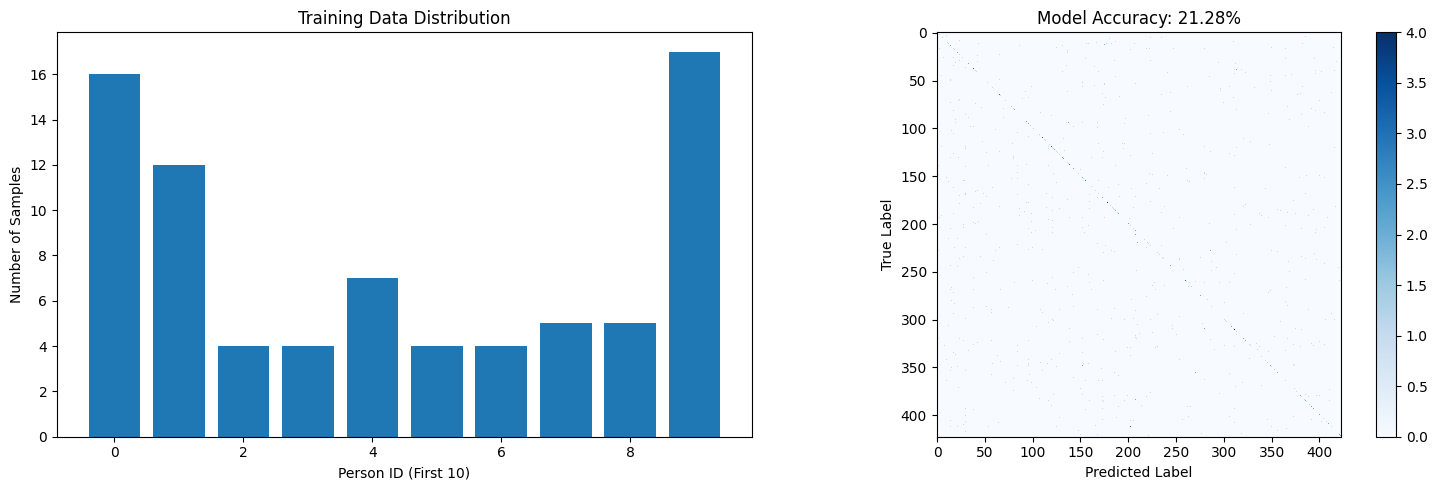


Classification Report:
                                 precision    recall  f1-score   support

                   Abdullah_Gul       0.50      0.67      0.57         3
                   Adrien_Brody       0.00      0.00      0.00         0
                  Ahmed_Chalabi       0.33      1.00      0.50         1
                    Ai_Sugiyama       0.00      0.00      0.00         1
                        Al_Gore       0.00      0.00      0.00         1
                    Al_Sharpton       1.00      0.33      0.50         3
                 Alan_Greenspan       0.00      0.00      0.00         1
              Alastair_Campbell       0.00      0.00      0.00         0
                   Albert_Costa       0.00      0.00      0.00         1
               Alejandro_Toledo       0.00      0.00      0.00         3
                      Ali_Naimi       1.00      0.50      0.67         2
                  Allyson_Felix       0.00      0.00      0.00         1
                   Alvaro_

In [63]:
# -----------------------------------------------------------------
# 8. --- MAIN SCRIPT (PART 1: TRAINING) ---
# -----------------------------------------------------------------
#
# RUN THIS CELL *AFTER* THE CELL CONTAINING THE CLASS DEFINITION
#
try:
    # Download and get dataset path
    # (Using the download function that worked for you)
    dataset_path = download_and_extract_lfw()

    if dataset_path:
        # Initialize system and process dataset
        print("Initializing Face Recognition System...")
        face_system = FaceRecognitionSystem()

        print("Processing dataset...")
        # Use max_samples_per_person=20 as seen in your output
        face_system.process_dataset(dataset_path, max_samples_per_person=20)

        # Train classifier and get results
        print(f"Training classifier on {len(face_system.embeddings)} samples...")
        results = face_system.train_classifier()

        # This block is now correctly indented
        if results is not None:
            # Plot and display results
            print("Plotting results...")
            face_system.plot_results(results)

            # Print classification report
            print("\nClassification Report:")
            y_true = face_system.le.inverse_transform(results['y_test'])
            y_pred = face_system.le.inverse_transform(results['y_pred'])
            # Setting zero_division=0 to avoid warnings for classes with no test samples
            print(classification_report(y_true, y_pred, zero_division=0))

            # Save model
            save_path = '/content/drive/MyDrive/face_recognition_model.pkl'

            # Check for drive directory
            if not os.path.exists('/content/drive/MyDrive'):
                os.makedirs('/content/drive/MyDrive')

            # Define model data to save
            model_data = {
                'classifier': face_system.classifier,
                'label_encoder': face_system.le
            }

            # Save the file
            with open(save_path, 'wb') as f:
                pickle.dump(model_data, f)
            print(f"Model saved to Google Drive: {save_path}")

        else: # This 'else' correctly aligns with 'if results is not None:'
            print("Training failed due to lack of data.")

except Exception as e:
    print(f"An error occurred during training: {str(e)}")
    raise


--- STARTING DEMO (WITH CORRECTED LOGIC) ---

Initializing demo system...
Loaded model. Testing on the 423 people it was trained on.
Getting test images...
Making predictions...
Displaying results...


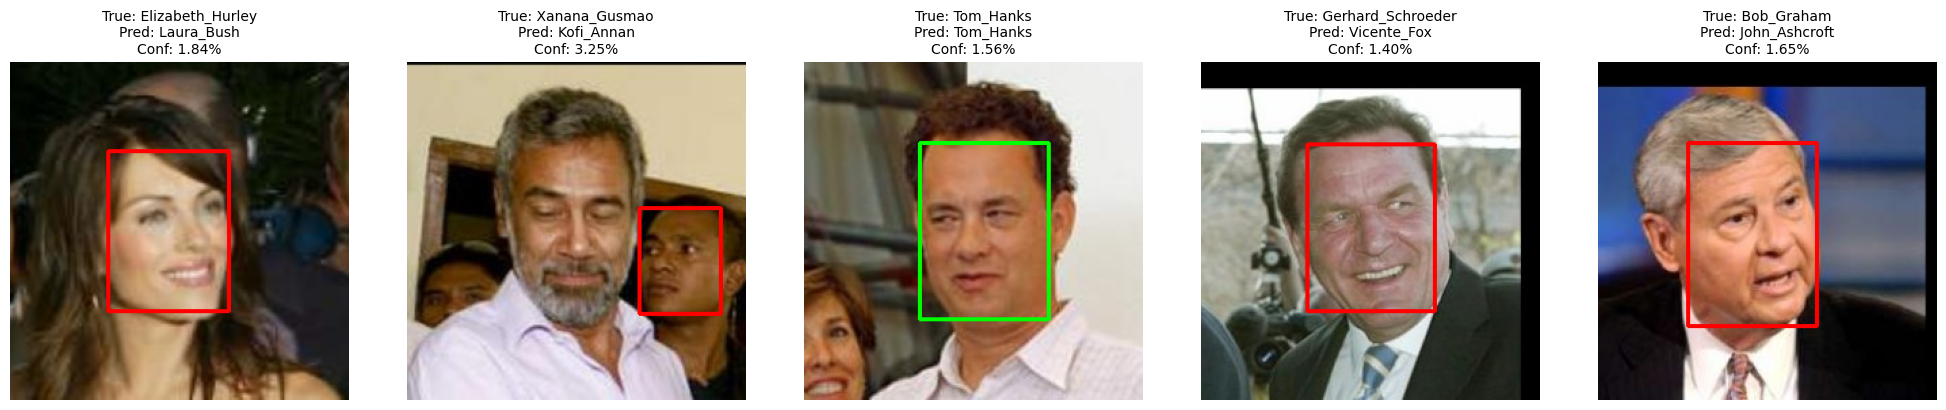


Detailed Demo Results:
  ✗ True: Elizabeth_Hurley     | Predicted: Laura_Bush           | Confidence: 1.84%
  ✗ True: Xanana_Gusmao        | Predicted: Kofi_Annan           | Confidence: 3.25%
  ✓ True: Tom_Hanks            | Predicted: Tom_Hanks            | Confidence: 1.56%
  ✗ True: Gerhard_Schroeder    | Predicted: Vicente_Fox          | Confidence: 1.40%
  ✗ True: Bob_Graham           | Predicted: John_Ashcroft        | Confidence: 1.65%

Test Accuracy on this random batch: 20.00%


In [65]:
# -----------------------------------------------------------------
# 9. --- MAIN SCRIPT (PART 2: DEMO) ---
# --- (RE-RUN WITH THIS CORRECTED CODE) ---
# -----------------------------------------------------------------

# --- MODIFICATION 1 ---
# This helper function is now changed to accept a list of 'known_people'
def get_random_test_images(lfw_path, known_people_list, num_images=5):
    """Gets random images *only from people the model knows*."""

    # Select 5 random people from the list of people the model was trained on
    selected_people = random.sample(list(known_people_list), num_images)

    test_images = []
    for person in selected_people:
        person_dir = os.path.join(lfw_path, person)
        images = os.listdir(person_dir)
        selected_image = random.choice(images)
        image_path = os.path.join(person_dir, selected_image)

        image = cv2.imread(image_path)
        test_images.append((person, image)) # Store (true_name, image_data)

    return test_images

def display_results(test_images, predictions):
    """Displays the test images with prediction results."""
    plt.figure(figsize=(20, 4))
    for i, ((true_name, image), (pred_name, confidence, face_box)) in enumerate(zip(test_images, predictions)):
        plt.subplot(1, len(test_images), i + 1)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if face_box:
            x1, y1, x2, y2 = face_box
            # Draw green rectangle for correct, red for incorrect
            color = (0, 255, 0) if true_name == pred_name else (255, 0, 0)
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color, 2)

            result_text = f"True: {true_name}\nPred: {pred_name}\nConf: {confidence:.2%}"
        else:
            result_text = f"True: {true_name}\nNo face detected"

        plt.imshow(image_rgb)
        plt.title(result_text, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- Main Demo Logic ---

print("\n" + "="*50)
print("--- STARTING DEMO (WITH CORRECTED LOGIC) ---")
print("="*50 + "\n")

try:
    # Define model path and dataset path
    model_path = '/content/drive/MyDrive/face_recognition_model.pkl'
    lfw_path = '/content/lfw' # Path where data was downloaded

    # Initialize the demo system
    print("Initializing demo system...")
    demo_system = FaceRecognitionDemo(model_path)

    # --- MODIFICATION 2 ---
    # Get the list of people the model actually knows from the encoder
    known_people = demo_system.le.classes_
    print(f"Loaded model. Testing on the {len(known_people)} people it was trained on.")

    # Get random test images *only from the known list*
    print("Getting test images...")
    test_images = get_random_test_images(lfw_path, known_people_list=known_people, num_images=5)

    # Make predictions
    print("Making predictions...")
    predictions = []
    for (true_name, image) in test_images:
        pred_name, confidence, face_box = demo_system.predict(image)
        predictions.append((pred_name, confidence, face_box))

    # Display results
    print("Displaying results...")
    display_results(test_images, predictions)

    # Calculate and display simple test accuracy
    correct_predictions = 0
    total_predictions = 0

    print("\nDetailed Demo Results:")
    for (true_name, _), (pred_name, confidence, _) in zip(test_images, predictions):
        if pred_name is not None and true_name is not None:
            total_predictions += 1
            status = "✓" if true_name == pred_name else "✗"
            if true_name == pred_name:
                correct_predictions += 1
            print(f"  {status} True: {true_name:<20} | Predicted: {pred_name:<20} | Confidence: {confidence:.2%}")
        else:
            print(f"  - True: {true_name:<20} | Prediction: No face detected")

    if total_predictions > 0:
        demo_accuracy = (correct_predictions / total_predictions) * 100
        print(f"\nTest Accuracy on this random batch: {demo_accuracy:.2f}%")
    else:
        print("\nNo faces were detected in the random batch.")

except Exception as e:
    print(f"An error occurred during the demo: {str(e)}")
    raise
